In [62]:
import numpy as np              
import pandas as pd             
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score, cohen_kappa_score, log_loss, classification_report

np.random.seed(45)

In [2]:
df = pd.read_csv('Car_Insurance_Claim.csv')

In [3]:
df.head()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


## О датасете
Данный датасет о страховании автомобилей. Имеет колонки:

- `ID` - уникальный индификатор клиента
- `AGE` - возраст клиента `(['65+', '16-25', '26-39', '40-64'])`
- `GENDER` - пол клиента `(['female', 'male'])`
- `RACE` - принадлежность к группе `(['majority', 'minority'])`
- `DRIVING_EXPERIENCE` - стаж вождения клиента `(['0-9y', '10-19y', '20-29y', '30y+'])`
- `EDUCATION` - образование клиента `(['high school', 'none', 'university'])`
- `INCOME` - экономический класс клиента `(['upper class', 'poverty', 'working class', 'middle class'])`
- `CREDIT_SCORE` - кредитный рейтинг клиента/рейтинг доверия клиенту `(from 0 to 1)`
- `VEHICLE_OWNERSHIP` - владеет ли автомобилем клиент `({0, 1})`
- `VEHICLE_YEAR` - год выпуска автомобиля `(['after 2015', 'before 2015'])`
- `MARRIED` - семейный статус `({0, 1})`
- `CHILDREN` - наличие детей `({0, 1})`
- `POSTAL_CODE` - почтовые данные `([10238, 32765, 92101, 21217])  `
- `ANNUAL_MILEAGE` - пробег автомобиля
- `VEHICLE_TYPE` - тип автомобиля `(['sedan', 'sports car'])`
- `SPEEDING_VIOLATIONS` - кол-во штрафов за привышение скорости
- `DUIS` - кол-во штрафов за вождение в нетрезвом виде
- `PAST_ACCIDENTS` - кол-во инцидентов в прошлом    
- `OUTCOME` - обратился ли клиент за страховыми выплатами `({0, 1})`

**Задача:** (Бинарная задача классификации) 

Основываясь на данных о клиенте, определить в каком случае клиент обратиться за страховыми выплатами, а в каком нет. 

## Анализ датасета

In [4]:
print("Число объектов:", df.shape[0])
print("Число признаков:", df.shape[1])

Число объектов: 10000
Число признаков: 19


In [5]:
print("Кол-во классов классификации:", len(df.OUTCOME.unique()))

Кол-во классов классификации: 2


In [6]:
df.isnull().sum()

ID                       0
AGE                      0
GENDER                   0
RACE                     0
DRIVING_EXPERIENCE       0
EDUCATION                0
INCOME                   0
CREDIT_SCORE           982
VEHICLE_OWNERSHIP        0
VEHICLE_YEAR             0
MARRIED                  0
CHILDREN                 0
POSTAL_CODE              0
ANNUAL_MILEAGE         957
VEHICLE_TYPE             0
SPEEDING_VIOLATIONS      0
DUIS                     0
PAST_ACCIDENTS           0
OUTCOME                  0
dtype: int64

Пропуски наблюдаются в колонках CREDIT_SCORE и ANNUAL_MILEAGE

In [7]:
# Процентное соотношение кол-ва пропусков
df.isnull().sum()*100/(df.count()+df.isnull().sum())

ID                     0.00
AGE                    0.00
GENDER                 0.00
RACE                   0.00
DRIVING_EXPERIENCE     0.00
EDUCATION              0.00
INCOME                 0.00
CREDIT_SCORE           9.82
VEHICLE_OWNERSHIP      0.00
VEHICLE_YEAR           0.00
MARRIED                0.00
CHILDREN               0.00
POSTAL_CODE            0.00
ANNUAL_MILEAGE         9.57
VEHICLE_TYPE           0.00
SPEEDING_VIOLATIONS    0.00
DUIS                   0.00
PAST_ACCIDENTS         0.00
OUTCOME                0.00
dtype: float64

Заполним пропуски медианным значением

In [8]:
values = {"CREDIT_SCORE": df.CREDIT_SCORE.median(), "ANNUAL_MILEAGE": df.ANNUAL_MILEAGE.median()}
df = df.fillna(value=values)

In [9]:
print(f'Соотношение классов: {df.OUTCOME[df.OUTCOME == 1].count()}/{df.OUTCOME[df.OUTCOME == 0].count()} (данные несбалансированы)')

Соотношение классов: 3133/6867 (данные несбалансированы)


Еще уберем `ID` из датасета, т.к. это переменная не несет никакой информации, кроме уникальности каждого клиента.

In [10]:
df = df.drop(columns='ID')

А еще нерелевантным мне кажется `POSTAL_CODE`, т.к. это маловероятно, что почтовый адрес влияет на выплату или не выплату страховки 

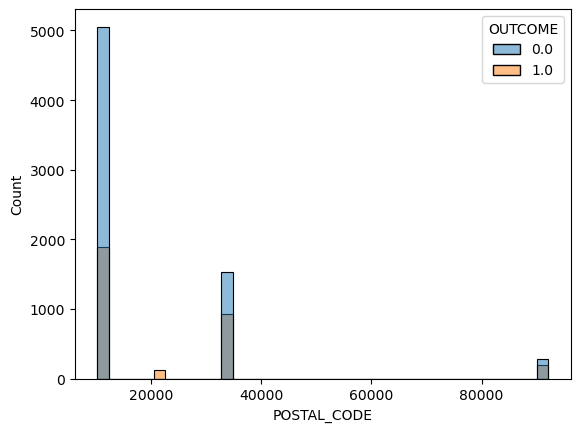

In [11]:
sns.histplot(data=df, x='POSTAL_CODE', hue='OUTCOME');

Здесь скорее вероятно то, что людей с "первым" адресом просто больше остальных.

In [12]:
df = df.drop(columns='POSTAL_CODE')

Что-то подобное и со столбцом `RACE`

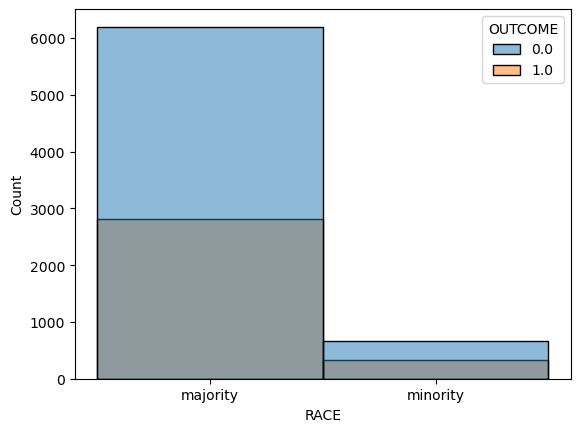

In [13]:
sns.histplot(data=df, x='RACE', hue='OUTCOME');

Так что от него тоже избавимся

In [14]:
df = df.drop(columns='RACE')

Удалим дубликаты

In [15]:
print('Первоначальное кол-во данных:', df.shape[0])
df = df.drop_duplicates()
print('Кол-во данных после удаления дубликатов:', df.shape[0])

Первоначальное кол-во данных: 10000
Кол-во данных после удаления дубликатов: 9972


Как видим, в данных было небольшое кол-во дубликатов

## EDA

Посмотрим сначала на те зависимости, которые напрашываются из жизни. Кто скорее всего вернется за страховыми взносами? Предположим, что тот, у кого мало опыта вождения (`DRIVING_EXPERIENCE`), тот, кто еще молод (`AGE`), тот, кто имеет опасный стиль вождения (`GENDER`,`SPEEDING_VIOLATIONS`, `DUIS`, `PAST_ACCIDENTS`, `CREDIT_SCORE`), тот, кого могла подвести машина (`ANNUAL_MILEAGE`, `VEHICLE_YEAR`)

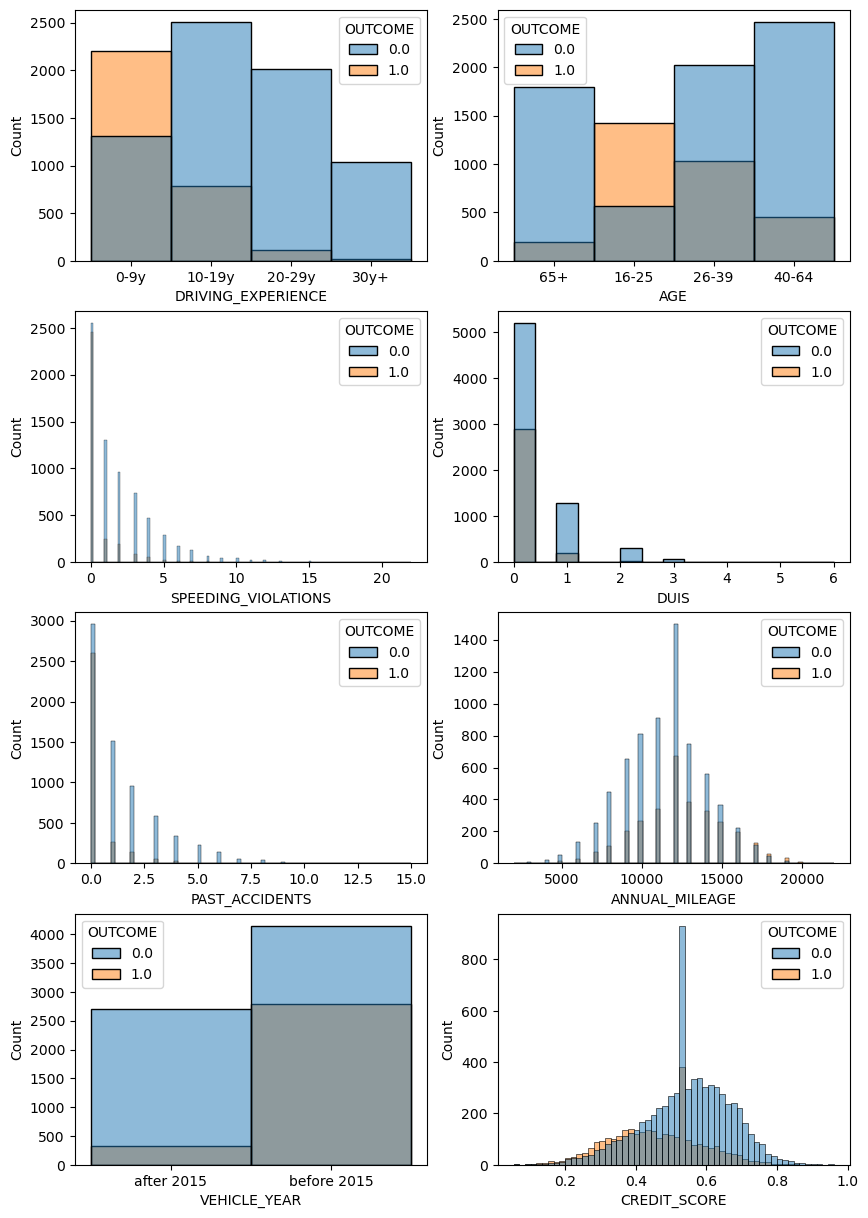

In [16]:
fig, axes = plt.subplots(4, 2, figsize=(10, 15))
sns.histplot(data=df, x='DRIVING_EXPERIENCE', hue='OUTCOME', ax=axes[0,0]);
sns.histplot(data=df, x='AGE', hue='OUTCOME', ax=axes[0,1]);
sns.histplot(data=df, x='SPEEDING_VIOLATIONS', hue='OUTCOME', ax=axes[1,0]);
sns.histplot(data=df, x='DUIS', hue='OUTCOME', ax=axes[1,1]);
sns.histplot(data=df, x='PAST_ACCIDENTS', hue='OUTCOME', ax=axes[2,0]);
sns.histplot(data=df, x='ANNUAL_MILEAGE', hue='OUTCOME', ax=axes[2,1]);
sns.histplot(data=df, x='VEHICLE_YEAR', hue='OUTCOME', ax=axes[3,0]);
sns.histplot(data=df, x='CREDIT_SCORE', hue='OUTCOME', ax=axes[3,1]);

Как и следовало ожидать, люди с опытом 0-9 лет обращаются намного чаще других за выплатами. Также более молодые водители склоны к требованию выплат. Но тут уже скорее есть небольшая корреляция между опытом вождения и возрастом. Т.к. видимо большинство получают права сразу, как им исполняется 16 лет, отсюда следует, что и их стаж пока им 16-25 лет будет 0-9 лет. 

Превышение скорости, вождение в пьяном виде, наличие прошлых инцидентов - ничего особо нам не говорит. Километраж машины тоже имеет нормальное распределение в обоих случаях(выплаты и не выплаты), так что тоже не имеет особо ничего интересного. 

Интересен случай, когда машина младше 2015 года - тут обращение за выплатами достаточно весомо. 

И последний график показывает, что низкое кредитное доверие оправдывает себя, т.е. клиенты с низким рейтингом чаще обращались за выплатами.

Вообщем, складывается ощущение, что от некоторых признаков лучше избавиться, потому что они не особо влияют на результат, но чтобы в этом убедиться, лучше составить корреляционную матрицу.

### Выбросы

Если выбросы и есть в данных, то скорее они будут находится в колонках `CREDIT_SCORE`, `ANNUAL_MILEAGE`, `VEHICLE_TYPE`, `SPEEDING_VIOLATIONS`, `DUIS`, `PAST_ACCIDENTS`. Так что проверим их, тоже построив гистограммы распределений. (Конечно, для некоторых признаков мы уже имеем такие графики, но они будут построены еще раз для наглядности)

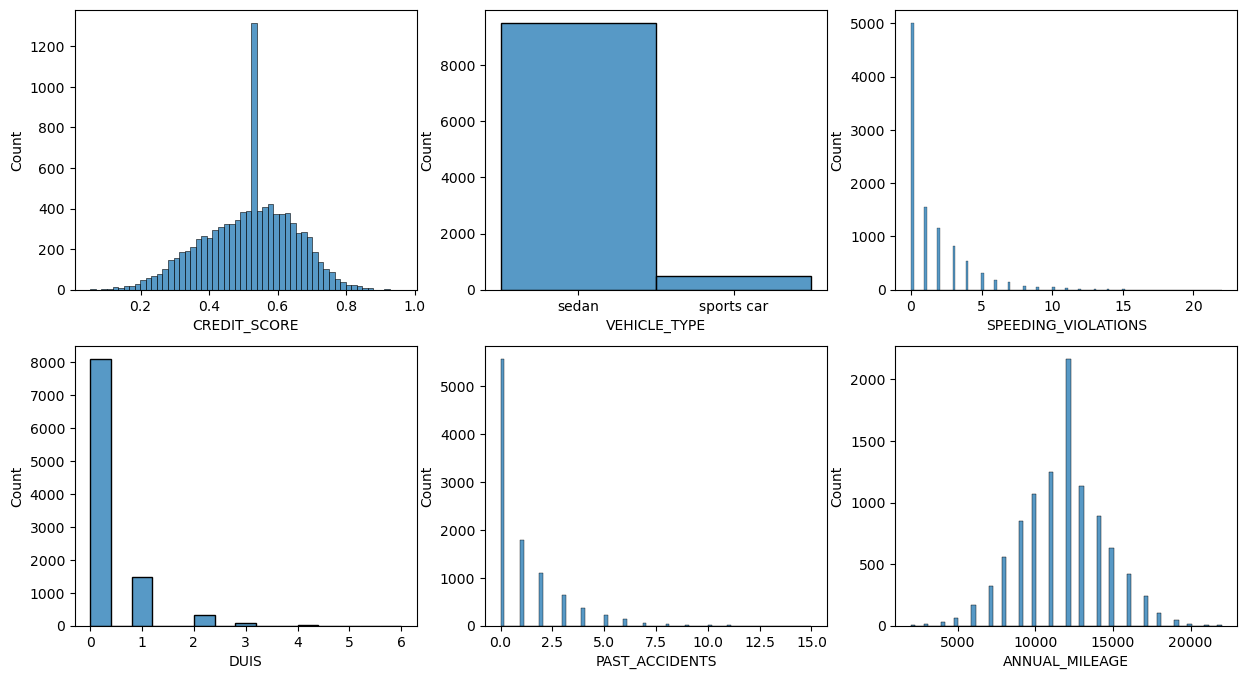

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
sns.histplot(data=df, x='CREDIT_SCORE', ax=axes[0,0]);
sns.histplot(data=df, x='VEHICLE_TYPE', ax=axes[0,1]);
sns.histplot(data=df, x='SPEEDING_VIOLATIONS', ax=axes[0,2]);
sns.histplot(data=df, x='DUIS', ax=axes[1,0]);
sns.histplot(data=df, x='PAST_ACCIDENTS', ax=axes[1,1]);
sns.histplot(data=df, x='ANNUAL_MILEAGE', ax=axes[1,2]);

В данных есть небольшие выбросы, попробуем определить какие значения мы уже будем откидывать для каждого признака

In [18]:
cr_q_min = df.CREDIT_SCORE.quantile(0.01)
cr_q_max = df.CREDIT_SCORE.quantile(0.99)
print(f'0.01% клиентов имеет CREDIT_SCORE <= {cr_q_min} или CREDIT_SCORE >= {cr_q_max}')

sv_q = df.SPEEDING_VIOLATIONS.quantile(0.99)
print(f'0.01% клиентов имеет SPEEDING_VIOLATIONS >= {sv_q}')

d_q = df.DUIS.quantile(0.99)
print(f'0.01% клиентов имеет DUIS >= {d_q}')

pa_q = df.PAST_ACCIDENTS.quantile(0.99)
print(f'0.01% клиентов имеет PAST_ACCIDENTS >= {pa_q}')

am_q_min = df.ANNUAL_MILEAGE.quantile(0.01)
am_q_max = df.ANNUAL_MILEAGE.quantile(0.99)
print(f'0.01% клиентов имеет ANNUAL_MILEAGE <= {am_q_min} или ANNUAL_MILEAGE >= {am_q_max}')

0.01% клиентов имеет CREDIT_SCORE <= 0.20096132805253622 или CREDIT_SCORE >= 0.7896733825616854
0.01% клиентов имеет SPEEDING_VIOLATIONS >= 10.0
0.01% клиентов имеет DUIS >= 2.0
0.01% клиентов имеет PAST_ACCIDENTS >= 7.0
0.01% клиентов имеет ANNUAL_MILEAGE <= 5000.0 или ANNUAL_MILEAGE >= 18000.0


In [19]:
raws_before = df.shape[0]
df = df.loc[(df.CREDIT_SCORE >= cr_q_min) & (df.CREDIT_SCORE <= cr_q_max) \
       & (df.SPEEDING_VIOLATIONS <= sv_q) \
       & (df.DUIS <= d_q) \
       & (df.PAST_ACCIDENTS <= pa_q) \
       & (df.ANNUAL_MILEAGE >= am_q_min) & (df.ANNUAL_MILEAGE <= am_q_max)]
raws_after = df.shape[0]

In [20]:
print(f'Размер данных до удаления выбросов: {raws_before}, после: {raws_after}')
print('Процент выбросов:', (raws_before - raws_after)*100/raws_before)

Размер данных до удаления выбросов: 9972, после: 9439
Процент выбросов: 5.344965904532692


### Encoding and correlation matrix

Чтобы работать с корреляционной матрицей и в дальнейшем с моделями, нам надо закодировать наши категориальные данные. 

Т.к. наши данные несбалансированы, то скорее всего нам лучше воспользоваться TargetEncoder, который будет это учитывать. 

In [21]:
tenc = ce.TargetEncoder(smoothing=10) 
prepared_df = tenc.fit_transform(df.drop(columns='OUTCOME'), df.OUTCOME)

In [22]:
prepared_df['OUTCOME'] = df.OUTCOME

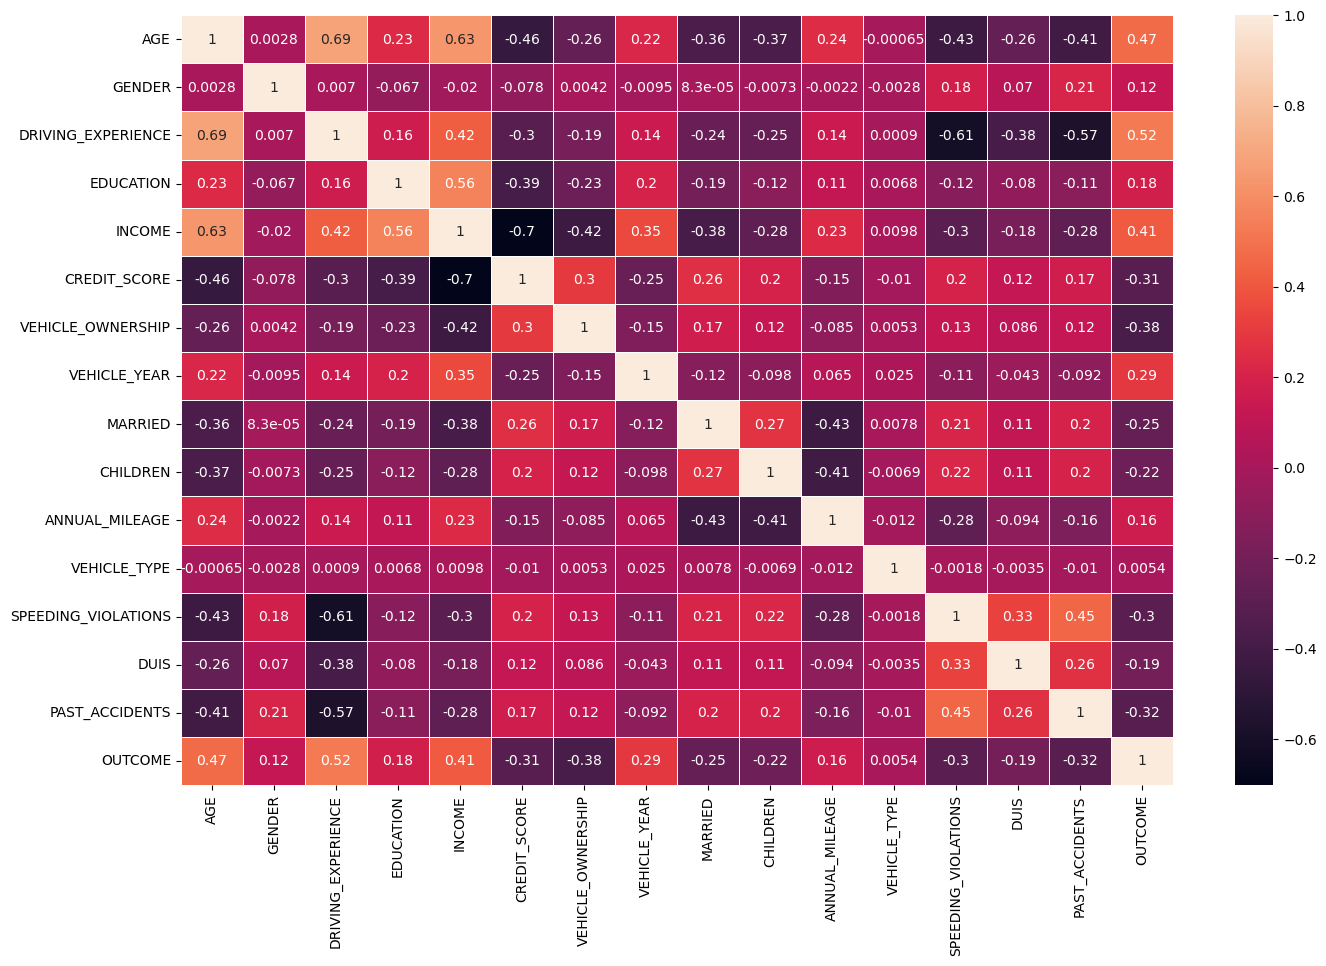

In [23]:
plt.figure(figsize = (16,10))
sns.heatmap(prepared_df.corr(), annot=True, linewidths=.5);

**Корреляция между признаками:**

Мы убедились, что стаж и возраст коррелируют друг с другом. Еще коррелируют возраст и доход, образование и доход, штрафы за скорость и инциденты.

**Корреляция между целевым признаком и другими:** 

С исходом больше всех коррелируют такие признаки, как возраст, стаж, доход.

Исходя из этого, я уберу колонки `AGE`, `EDUCATION`. 

In [24]:
prepared_df = prepared_df.drop(columns=['AGE', 'EDUCATION'])

Остальные признаки пока оставим и перейдем к обучению

## Обучение

Для обучения возьмем, пожалуй, такие модели, как **SVM, KNN, RandomForest**. Выбор обусловлен скорее тем, что это распространенные и достаточно простые модели для бинарной классификации. 

### Предобработка

Т.к. в SVM и KNN используется расстояние между объектами, то лучше наши данные отмасштабировать. 

In [25]:
prepared_df.head()

,GENDER,DRIVING_EXPERIENCE,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,0.261548,0.625259,0.137905,0.629027,1.0,0.110250,0.0,1.0,12000.0,0.315151,0,0,0,0.0
1,0.371897,0.625259,0.650387,0.357757,0.0,0.404091,0.0,0.0,16000.0,0.315151,0,0,0,1.0
2,0.261548,0.625259,0.455255,0.493146,1.0,0.404091,0.0,0.0,11000.0,0.315151,0,0,0,0.0
3,0.371897,0.625259,0.455255,0.206013,1.0,0.404091,0.0,1.0,11000.0,0.315151,0,0,0,0.0
4,0.371897,0.236267,0.455255,0.388366,1.0,0.404091,0.0,0.0,12000.0,0.315151,2,0,1,1.0


Причем масштабирование скорее нужно таким признакам, как `ANNUAL_MILEAGE`, `SPEEDING_VIOLATIONS`, `DUIS`, `PAST_ACCIDENTS`

In [26]:
col = ['GENDER', 'DRIVING_EXPERIENCE', 'INCOME', 'CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'VEHICLE_YEAR', 'MARRIED', 'CHILDREN', 'VEHICLE_TYPE']
scaler_col = ['ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS']

In [27]:
scaler = MinMaxScaler()
scaler_data = scaler.fit_transform(prepared_df.loc[:, scaler_col])

In [28]:
scaler_data = pd.DataFrame(scaler_data, columns=scaler_col, index=prepared_df[scaler_col].index)

In [29]:
prepared_df = pd.concat([prepared_df[col], scaler_data, prepared_df.OUTCOME], axis=1, join="inner")

Разделим данные на тренировочную и тестовую выборки

In [30]:
X_train, X_test, y_train, y_test = train_test_split(prepared_df.drop(columns='OUTCOME'), prepared_df.OUTCOME, \
                                                    test_size=0.3, random_state=42)

### Модели

In [31]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)

SVC(probability=True)

In [32]:
# Функция для пробегания по всем метрикам
def find_metrics(model) -> list:
    metrics_fun = [balanced_accuracy_score, f1_score, roc_auc_score, cohen_kappa_score]
    y_predict = model.predict(X_test)
    metrics = []
    for fun in metrics_fun:
        metrics.append(fun(y_test, y_predict))
    return metrics

In [33]:
print('Метрики у SVC:', find_metrics(svm))

Метрики у SVC: [0.797304970645747, 0.72, 0.797304970645747, 0.5922136348307381]


In [34]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [35]:
print('Метрики у KNN:',find_metrics(knn))

Метрики у KNN: [0.7712346356331716, 0.6864801864801864, 0.7712346356331716, 0.5503490984942343]


D:\Anaconda\Program\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [36]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [37]:
print('Метрики у RandomForestClassifier:', find_metrics(rfc))

Метрики у RandomForestClassifier: [0.7697874311087012, 0.68626274745051, 0.7697874311087011, 0.5560159855540088]


In [38]:
print("Ошибка на тесте у SVC:", log_loss(y_test, svm.predict_proba(X_test)))
print("Ошибка на тесте у KNN:", log_loss(y_test, knn.predict_proba(X_test)))
print("Ошибка на тесте у RandomForestClassifier:", log_loss(y_test, rfc.predict_proba(X_test)))

Ошибка на тесте у SVC: 0.405422844425343
Ошибка на тесте у KNN: 1.7004313768309736
Ошибка на тесте у RandomForestClassifier: 0.6495133396920334


Просто посмотрим на то, какие признаки оказались самыми важными при классификации у RandomForest

<AxesSubplot:>

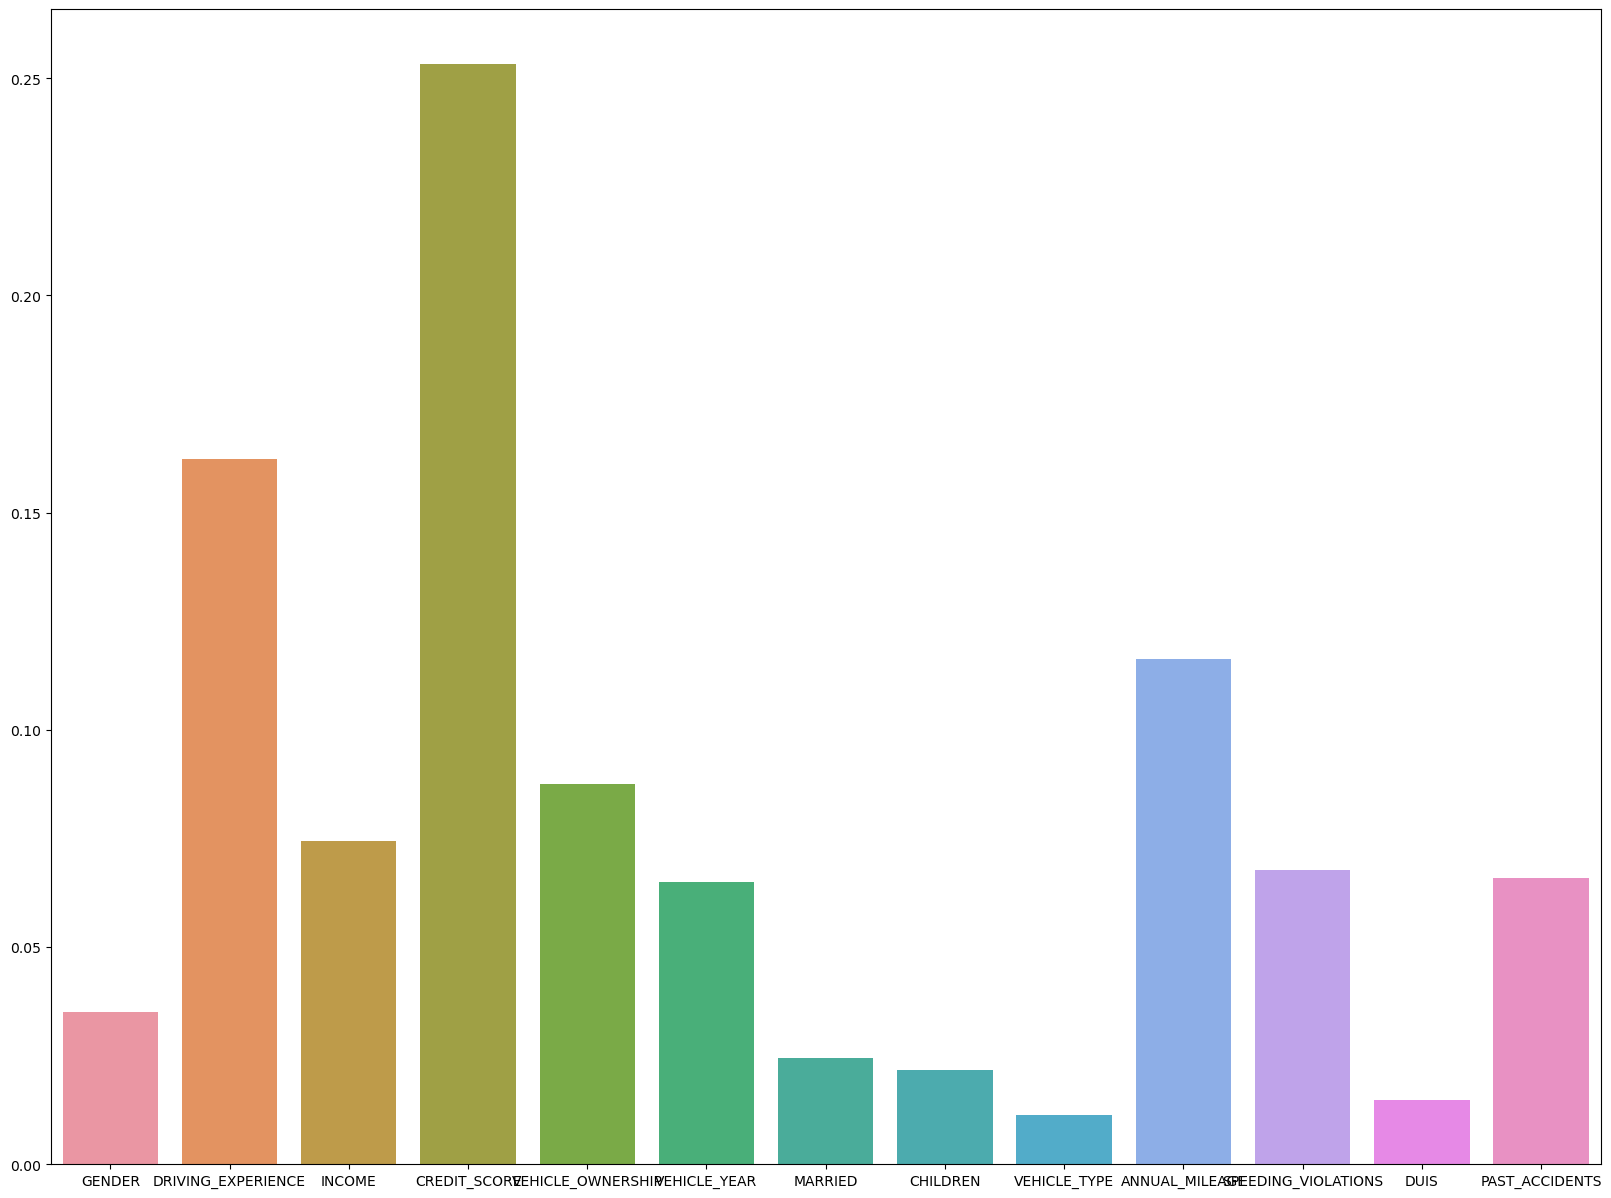

In [39]:
fig = plt.figure(figsize=(20, 15))
sns.barplot(x=col+scaler_col, y=rfc.feature_importances_)

Как и следовало ожидать, большее влияние оказали `CREDIT_SCORE`(который я даже выпустила из виду в начале), `DRIVING_EXPERIENCE`, `ANNUAL_MILEAGE`.

Теперь попробуем подобрать гиперпараметры. Первоначально я хотела остановиться на методе RandomForest, но потом захотелось экспериментов, поэтому в итоге подбор будет проведен у всех моделей.

In [46]:
param_grid = {'C': [0.001, 0.01, 0.1] + list(range(1,10)) + [50, 100, 150],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'gamma':['scale', 'auto'],
              'kernel': ['linear', 'rbf']}  
   
grid_svm = GridSearchCV(SVC(), param_grid, scoring='roc_auc')    
grid_svm.fit(X_train, y_train) 
 
print(grid_svm.best_params_) 
grid_predictions = grid_svm.predict(X_test) 
print(classification_report(y_test, grid_predictions))
print('Оценка SVM:', grid_svm.score(X_test, y_test))

{'C': 150, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87      1951
         1.0       0.72      0.70      0.71       881

    accuracy                           0.82      2832
   macro avg       0.79      0.79      0.79      2832
weighted avg       0.82      0.82      0.82      2832

Оценка SVM: 0.8870921574023276


In [47]:
import warnings
warnings.filterwarnings("ignore") 

param_grid = {'n_neighbors': [5, 10, 50, 60, 70, 80, 90, 100, 150, 200],  
              'p': [1, 2]}  
   
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='roc_auc') 
grid_knn.fit(X_train, y_train) 
 
print(grid_knn.best_params_) 
grid_predictions = grid_knn.predict(X_test) 
print(classification_report(y_test, grid_predictions))
print('Оценка KNN:', grid_knn.score(X_test, y_test))

{'n_neighbors': 60, 'p': 1}
              precision    recall  f1-score   support

         0.0       0.88      0.87      0.88      1951
         1.0       0.73      0.74      0.73       881

    accuracy                           0.83      2832
   macro avg       0.80      0.81      0.80      2832
weighted avg       0.83      0.83      0.83      2832

Оценка KNN: 0.8821134829427675


In [48]:
param_grid = {'n_estimators': [5, 10, 50, 60, 70, 80, 90, 100, 150, 200],  
              'criterion': ['gini', 'entropy', 'log_loss'],
              'min_samples_leaf': [1, 2, 3, 4],
              'min_samples_split': [2, 3, 4, 5]}  
   
grid_rfc = GridSearchCV(RandomForestClassifier(), param_grid, scoring='roc_auc') 
grid_rfc.fit(X_train, y_train) 
 
print(grid_rfc.best_params_) 
grid_predictions = grid_rfc.predict(X_test) 
print(classification_report(y_test, grid_predictions))
print('Оценка RandomForest:', grid_rfc.score(X_test, y_test))

{'criterion': 'entropy', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 60}
              precision    recall  f1-score   support

         0.0       0.87      0.90      0.89      1951
         1.0       0.76      0.70      0.73       881

    accuracy                           0.84      2832
   macro avg       0.82      0.80      0.81      2832
weighted avg       0.84      0.84      0.84      2832

Оценка RandomForest: 0.8872451683731559


In [64]:
# Проверим еще результат на метриках, которые выбирали первоначально. 
# Т.к. некоторые из этих метрик нужны именно для оценки несбалансированных данных (balanced_accuracy_score, cohen_kappa_score).
# Напоминаем, что метрики следуют в данном порядке:
# balanced_accuracy_score, f1_score, roc_auc_score, cohen_kappa_score
print('Метрики у SVC:', find_metrics(grid_svm))
print('Метрики у KNN:', find_metrics(grid_knn))
print('Метрики у RandomForest:', find_metrics(grid_rfc))

Метрики у SVC: [0.7899997149225259, 0.7119815668202765, 0.7899997149225259, 0.5847314919576918]
Метрики у KNN: [0.8061106647483086, 0.731981981981982, 0.8061106647483086, 0.6095650808858839]
Метрики у RandomForest: [0.8020997992240075, 0.7316784869976358, 0.8020997992240074, 0.6176571520672589]


## Вывод

В целом все модели стали лучше после подбора гиперпараметров, кроме SVC(видимо, она немного переобучилась). 

Первое место по качеству занимает KNN, второе прям с очень маленьким отрывом - RandomForest. Их показатели в районе 0.8

Мной также была введена метрика cohen_kappa_score. Хотя она скорее всего хороша, когда надо предсказывать не два класса, а больше. Но мне хотелось ее попробовать, т.к. опять же - наши данные были несбалансированы, поэтому хотелось не забывать об этом и следить как-то. Оценка Каппа Коэна небольшая, но она отвечает за согласованность (между реальными исходами и тем, что мы предсказали) и показатель в 0.61, что наши предсказания все-таки хорошие для несбалансированных данных. 